In [20]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from PIL import Image
from scipy.io import loadmat
from scipy.spatial.distance import pdist

from sklearn import ensemble
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer
from statistics import mean
import time

from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from keras.callbacks import EarlyStopping
from keras import models
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.utils.np_utils import to_categorical

## Fundamental Configurations

In [4]:
"""
Path
"""
DATA_PATH = "../data/train_set"
IMAGE_FOLDER = os.path.join(DATA_PATH, "images")
POINTS_FOLDER = os.path.join(DATA_PATH, "points")
LABELS_FOLDER = DATA_PATH

RANDOM_SEED = 13

## Data Import

In [2]:
def read_all_images(height = 750, width = 1000, crop_gray = False, points = None):
    """
    Read 2500 training images from the IMAGE_FOLDER, resized to 'height x width'
    
    :param height: resized height of images
    :param width: resized width of images
    :return: a 4d numpy array in form of (index, height, width, channels), channels is RGB 
    """
    files = [file for file in os.listdir(IMAGE_FOLDER) if file.endswith('.jpg')]
    files.sort()
    
    
    face_images_arr = np.zeros((len(files), height, width, 1 if crop_gray else 3 ))
    
    for index, filename in enumerate(files):
        face_img = Image.open(os.path.join(IMAGE_FOLDER, filename))
        # if crop_gray, then the image will be cropped to fit the facial part
        # and then it will return a grayscale version
        if crop_gray:
            face_img = face_img.convert('L')

            face_points = points[index]
            # calculate crop position
            left = np.min(face_points[:,0]) 
            right = np.max(face_points[:,0]) 
            top = np.min(face_points[:,1])
            bot = np.max(face_points[:,1])

            face_img = face_img.crop((left,top,right,bot))
        
        face_img = face_img.resize((width, height))
        # fit the dimension
        face_images_arr[index] = np.array(face_img).reshape((height,width, -1))
        
    return face_images_arr

def read_labels():
    """
    Read the image labels from the label.csv file
    :return: a pandas.DataFrame with 3 columns: 'emotion_idx','emotion_cat','type'
    """
    labels_df = pd.read_csv(os.path.join(LABELS_FOLDER, 'label.csv'))
    labels_df = labels_df.loc[:,['emotion_idx','emotion_cat','type']]
    return labels_df
    

def read_all_points():
    """
    Read all face coordinates points
    :return: a tuple of shape (2500, 78, 2). Because for each of 2500 images there are 78 points associated with it
    """
    files = [file for file in os.listdir(POINTS_FOLDER) if file.endswith('.mat')]
    files.sort()
    
    face_points = np.zeros((len(files), 78, 2))
    for index, filename in enumerate(files):
        face_points_dict = loadmat(os.path.join(POINTS_FOLDER, filename))
    
        face_points[index] = face_points_dict.get('faceCoordinatesUnwarped',  face_points_dict.get('faceCoordinates2'))
    return face_points

def load_data(loadImage = False, height = 750, width = 1000, crop_gray = False):
    """
    Load training data from local files
    
    :param loadImage: if it's False, this function will not load original images
    :return: a tuple (images, points, labels)
        if loadImage is False, the 'images' will None. Otherwise its a numpy array with shape (2500,750,1000,3)
        points is a numpy array with shape (2500, 78, 2)
        labels is a pandas.DataFrame
    """
    
    face_images_points = read_all_points()
    
    face_images_ndarr =  read_all_images(height, width, crop_gray, face_images_points) if loadImage else None
    labels = read_labels()
    
    return face_images_ndarr, face_images_points, labels



def show_image(index, all_images = None):
    """
    Display the (index)th image.
    all_images is passed, the this image numpy array can be easily retrieved from it. 
    Otherwise the original images needs to be read from disk
    
    :param index: the index to specify which image to disply
    :param all_images: the return value of 'read_all_images' function
    """
    
    if all_images is not None and index < len(all_images):
        face_img_arr = all_images[index].astype('uint8')
        if face_img_arr.shape[2] == 1:
            face_img_arr = face_img_arr.reshape((face_img_arr.shape[0],face_img_arr.shape[1]))
    else:
        face_img_arr = plt.imread(os.path.join(IMAGE_FOLDER, f"{index:04}.jpg"))
    plt.imshow(face_img_arr, cmap='gray')
    plt.show()


In [5]:
"""
Read images with 200x200 resolution and facial points, labels
"""
height = 200
width = 200
images, points, labels = load_data(loadImage= False,crop_gray=True, height = height, width = width)

In [6]:
if images is not None:
    print("shape of image",images.shape)
    print(f"memory of image ndarray is {sys.getsizeof(images)/1024/1024/1024:.2f} GB")
if points is not None:
    print("shape of points",points.shape)

shape of points (2500, 78, 2)


## Data Preprocessing And Data Featuring

In [12]:
"""
Preprocessing
"""

X_distances = np.zeros((2500, 3003))
for i in range(2500):
    current = points[i]
    X_distances[i,] = pdist(current)


X_points = points.reshape((points.shape[0], -1))

y = labels['emotion_idx'].values - 1

print(X_distances.shape,X_points.shape, y.shape)

(2500, 3003) (2500, 156) (2500,)


## Baseline Model

###### Time: 94.284029s ######
###### Time: 95.914360s ######
###### Time: 97.368861s ######
###### Time: 94.959776s ######


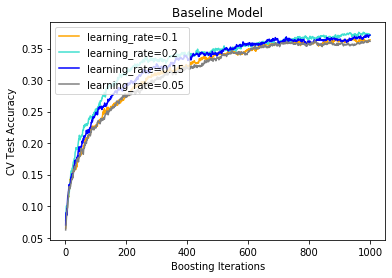

In [21]:
X = X_distances
Y = labels['emotion_idx']
plt.figure()
original_params = {'n_estimators': 1000, 'max_features': 1, 'max_depth': 1,
                   'learning_rate': 0.1}
for label, color, setting in [('learning_rate=0.1','orange',
                               {'learning_rate':0.1}),
                              ('learning_rate=0.2','turquoise',
                               {'learning_rate':0.2}),
                              ('learning_rate=0.15','blue',
                               {'learning_rate':0.15}),
                              ('learning_rate=0.05','gray',
                               {'learning_rate':0.1})]: 
    start_time = time.time()
    skf = StratifiedKFold(n_splits = 5, random_state = 666)
    params = dict(original_params)
    base_score = np.zeros((5,params['n_estimators']), dtype=np.float64)                              
    params.update(setting)
    clf = ensemble.GradientBoostingClassifier(**params)
    
    for j, (train_index, test_index) in zip(range(5), skf.split(X, Y)):
        X_train, Y_train = X[train_index], Y[train_index]
        X_test, Y_test = X[test_index], Y[test_index]
        clf.fit(X_train, Y_train)

        for i, Y_pred in enumerate(clf.staged_predict(X_test)):
            base_score[j,i] = accuracy_score(Y_test, Y_pred)
        
    score = [mean(base_score[:,i]) for i in range(1000)]
    plt.plot(range(1, 1001), score, color=color, label=label)
    print("###### Time: %f" % (time.time() - start_time) + "s ######")

plt.legend(loc='upper left')
plt.xlabel('Boosting Iterations')
plt.ylabel('CV Test Accuracy')
plt.title('Baseline Model')
plt.show()

###### Time: 93.063822s ######
###### Time: 105.025655s ######
###### Time: 106.438205s ######
###### Time: 105.194551s ######
###### Time: 98.242049s ######


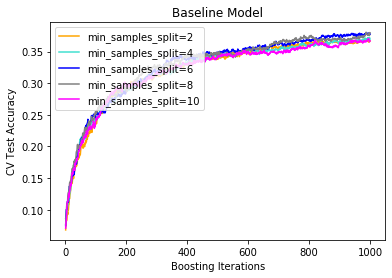

In [37]:

plt.figure()
original_params.update({'learning_rate':0.2})
for label, color, setting in [('min_samples_split=2','orange',
                               {'min_samples_split':2}),
                              ('min_samples_split=4','turquoise',
                               {'min_samples_split':4}),
                              ('min_samples_split=6','blue',
                               {'min_samples_split':6}),
                              ('min_samples_split=8','gray',
                               {'min_samples_split':8}),
                             ('min_samples_split=10','magenta',
                               {'min_samples_split':10})]: 
    start_time = time.time()
    skf = StratifiedKFold(n_splits = 5, random_state = 666)
    params = dict(original_params)
    base_score = np.zeros((5,params['n_estimators']), dtype=np.float64)                              
    params.update(setting)
    clf = ensemble.GradientBoostingClassifier(**params)
    
    for j, (train_index, test_index) in zip(range(5), skf.split(X, Y)):
        X_train, Y_train = X[train_index], Y[train_index]
        X_test, Y_test = X[test_index], Y[test_index]
        clf.fit(X_train, Y_train)

        for i, Y_pred in enumerate(clf.staged_predict(X_test)):
            base_score[j,i] = accuracy_score(Y_test, Y_pred)
        
    score = [mean(base_score[:,i]) for i in range(1000)]
    plt.plot(range(1, 1001), score, color=color, label=label)
    print("###### Time: %f" % (time.time() - start_time) + "s ######")

plt.legend(loc='upper left')
plt.xlabel('Boosting Iterations')
plt.ylabel('CV Test Accuracy')
plt.title('Baseline Model')
plt.show()

In [ ]:
plt.figure()
original_params.update({'min_samples_split':4})
for label, color, setting in [('min_samples_leaf=1','orange',
                               {'min_samples_leaf':1}),
                              ('min_samples_leaf=2','turquoise',
                               {'min_samples_leaf':2}),
                              ('min_samples_leaf=3','blue',
                               {'min_samples_leaf':3}),
                              ('min_samples_leaf=4','gray',
                               {'min_samples_leaf':4}),
                             ('min_samples_leaf=5','magenta',
                               {'min_samples_leaf':5})]: 
    start_time = time.time()
    skf = StratifiedKFold(n_splits = 5, random_state = 666)
    params = dict(original_params)
    base_score = np.zeros((5,params['n_estimators']), dtype=np.float64)                              
    params.update(setting)
    clf = ensemble.GradientBoostingClassifier(**params)
    
    for j, (train_index, test_index) in zip(range(5), skf.split(X, Y)):
        X_train, Y_train = X[train_index], Y[train_index]
        X_test, Y_test = X[test_index], Y[test_index]
        clf.fit(X_train, Y_train)

        for i, Y_pred in enumerate(clf.staged_predict(X_test)):
            base_score[j,i] = accuracy_score(Y_test, Y_pred)
        
    score = [mean(base_score[:,i]) for i in range(1000)]
    plt.plot(range(1, 1001), score, color=color, label=label)
    print("###### CV Score: %f" % max(score))
    print("###### Time: %f" % (time.time() - start_time) + "s ######")

plt.legend(loc='upper left')
plt.xlabel('Boosting Iterations')
plt.ylabel('CV Test Accuracy')
plt.title('Baseline Model')
plt.show()

In [ ]:
start_time = time.time()
chosen_params = {'min_samples_leaf':1, 'min_samples_split':4, 'learning_rate':0.2,
                'n_estimators':10000, 'max_features':1, 'max_depth':1}
chosen_baseline = ensemble.GradientBoostingClassifier(**chosen_params)
chosen_baseline.fit(X,Y)
print("###### Model Training Time: %f" % (time.time() - start_time) + "s ######")

In [ ]:
emotion_cat = {x[0]:x[1] for x in labels.values}
emotion_type = {x[0]:x[2] for x in labels.values}

def baseline_predict(Xtest, Ytest = None, output = True):
    clf = chosen_baseline
    Ypred = clf.predict(Xtest)
    if Ytest is not None:
        score = accuracy_score(Ytest, Ypred)
        print("###### Accuracy: %f" % score + " ######")
    if output:
        d = {'emotion_idx':Ypred, 'emotion_cat':[emotion_cat.get(key) for key in Ypred],
             'type':[emotion_type.get(key) for key in Ypred]}
        #cat = [emotion_cat.get(key) for key in Ypred]
        #type = [emotion_type.get(key) for key in Ypred]
        df = pd.DataFrame(data = d)
        df.to_csv('../output/baseline_prediction.csv')
        

## Improved Model - Feedforward Neural Network

In [13]:
def create_ff_model(input_shape, hidden_layers = (512,) , outputs = 22, optimizer = 'adam'):
    """
    Create a feedforward model without any regularization
    
    :param input_shape: the size of input a 2-tupple
    :param hidden_layers: the hidden units of each hidden layers
    :param outputs: the number of expected output labels
    
    :return: compiled feedforwad nn model
    """
    if len(hidden_layers) < 1:
        raise Exception("Wrong parameter for hidden layer units")
        
    ff_model = models.Sequential()
    
    # input layer
    ff_model.add(layers.Dense(hidden_layers[0], activation='relu', input_shape = input_shape))
                 
    # add hidden layers
    for index in range(1, len(hidden_layers)):
        ff_model.add(layers.Dense(hidden_layers[index], activation='relu'))
    
    # output layer
    ff_model.add(layers.Dense(outputs, activation='softmax'))
    # rmsprop
    
    ff_model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics = ['acc'])
    
    return ff_model

In [14]:
def create_regularized_ff_model(input_shape, hidden_layers = (512,) , outputs = 22, optimizer = 'adam', l2 = 0.01):
    """
    Create a feedforward model `with` any regularization
    
    :param input_shape: the size of input a 2-tupple
    :param hidden_layers: the hidden units of each hidden layers
    :param outputs: the number of expected output labels
    
    :return: compiled feedforwad nn model
    """
    if len(hidden_layers) < 1:
        raise Exception("Wrong parameter for hidden layer units")
        
    ff_model = models.Sequential()
    
    l2_regularizer = regularizers.l2(l2)
    
    # input layer
    ff_model.add(layers.Dense(hidden_layers[0], activation='relu', input_shape = input_shape, kernel_regularizer = l2_regularizer))
#     ff_model.add(layers.Dropout(0.5))         
    # add hidden layers
    for index in range(1, len(hidden_layers)):
        ff_model.add(layers.Dense(hidden_layers[index], activation='relu', kernel_regularizer = l2_regularizer))
#         ff_model.add(layers.Dropout(0.5))
    # output layer
    ff_model.add(layers.Dense(outputs, activation='softmax'))
    # rmsprop
    
    ff_model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics = ['acc'])
    
    return ff_model

In [15]:
def k_fold_feedforward_points(model, X, y, fold = 5, random_state = 13):
    """
    Run k-fold cross validation for keras neural network model
    
    :param model_create_function: the function used to creat a compiled keras neural network model
    :param input_shape: the size of input a 2-tupple
    :param hidden_layer: the same as `create_ff_model` function
    :param X: the feature matrix
    :param y: the target
    :param fold: the number of fold
    :param random_state: random seed for k-fold splitting
    """
    
    # split folder
    kfold = StratifiedKFold(n_splits=fold, shuffle=True, random_state=random_state)
    
    avg_accuracy = 0
    histories = []
    # 5-fold 
    for train_index, val_index in kfold.split(X, y):
        # split traning set and validation set
        X_train = X[train_index]
        y_train = y[train_index]

        X_test = X[val_index]
        y_test = y[val_index]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test =scaler.transform(X_test)

        y_test = to_categorical(y_test)
        y_train = to_categorical(y_train)

        # early stopping
        callbacks = [
          EarlyStopping(
            monitor='val_loss', patience=5, verbose=0)
          ]


        history = model.fit(X_train,y_train,
                                         epochs = 20, 
                                        batch_size = 100,
                                         workers = 6,
                                         validation_data = (X_test, y_test),
                                        verbose = False,
                                        shuffle = True,
                                        callbacks = callbacks)
        histories.append(history)
        avg_accuracy += model.evaluate(X_test, y_test, verbose = False)[1]
    return histories, avg_accuracy / fold


In [16]:
def draw_training_validation_graph(history_obj):
    """
    Draw the loss and accuracy plot using the history_obj
    
    :param history_obj: the history object returned by calling fit method of keras' model
    
    """
    loss_values = history_obj.history['loss']
    val_loss_valus = history_obj.history['val_loss']
    acc = history_obj.history['acc']
    val_acc = history_obj.history['val_acc']
    
    epochs = range(1,len(val_loss_valus) + 1)
    
    fig, axs = plt.subplots(1,2, figsize = (16,4))

    axs[0].plot(epochs, loss_values, 'bo', label='Training Loss')
    axs[0].plot(epochs, val_loss_valus, 'r', label='Validation Loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    
    axs[1].plot(epochs, acc, 'bo', label='Training Acc')
    axs[1].plot(epochs, val_acc, 'r', label='Validation Acc')
    axs[1].set_title('Training and Validation Acc')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    
    
    plt.show()

In [17]:
neural_distances_histories = {}
for hidden_layer in [(512,512),(512,512,512),(1024,1024),(1024,1024,1024)]:
    model = create_regularized_ff_model((3003,), hidden_layer, optimizer = 'rmsprop', l2= 0.001)
    hist, acc = k_fold_feedforward_points(model, X_distances, y)
    neural_distances_histories[hidden_layer] = hist
    print("feedforward neural network with hidden layer :", hidden_layer , acc)

feedforward neural network with hidden layer : (512, 512) 0.5450844168663025
feedforward neural network with hidden layer : (512, 512, 512) 0.597538822889328
feedforward neural network with hidden layer : (1024, 1024) 0.5194609880447387
feedforward neural network with hidden layer : (1024, 1024, 1024) 0.5212423622608184


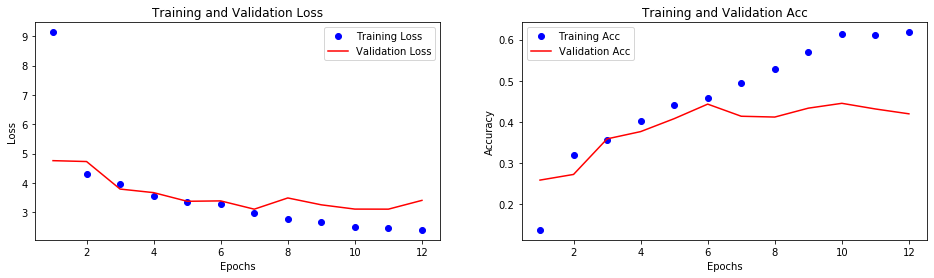

In [18]:
draw_training_validation_graph(neural_distances_histories[(512,512)][0])

In [22]:
"""
Measure the cross-validation time
"""
best_distances_nn_model = create_regularized_ff_model((3003,), (512,512, 512), l2= 0.001, optimizer='rmsprop')
%time hist,acc = k_fold_feedforward_points(best_distances_nn_model, X_distances,y)

CPU times: user 1min 23s, sys: 46.1 s, total: 2min 9s
Wall time: 28.6 s


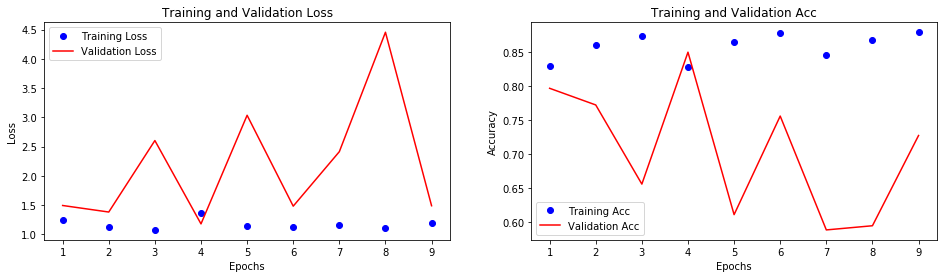

In [31]:
draw_training_validation_graph(hist[4])
# dir(best_distances_nn_model.ep

In [35]:
"""
Find the best epoch for the model
Retrain the neural network model using the best parameter set
"""
best_ff_model = create_regularized_ff_model((3003,), (512,512,512), optimizer = 'rmsprop', l2= 0.001)

scaler = StandardScaler()

X_dist_scaled = scaler.fit_transform(X_distances)
y_cat = to_categorical(y)

history = model.fit(X_dist_scaled,y_cat,
                                 epochs = 7, 
                                batch_size = 100,
                                 workers = 6,
                                verbose = False,
                                shuffle = True,
                                )

In [36]:
"""
Save the model
"""
# best_ff_model.save("../output/best_ff_model.h5")

## Summarizing Running Time


* Baseline Mode: 
    * Time For 5-fold Cros Validation: 
        * Total time: 469s
* Improved Model:
    * Time For 5-fold Cros Validation: 
        * CPU times: user 1min 23s, sys: 46.1 s, total: 2min 9s
        * Wall time: 28.6 s